This notebook is a first exploration of the Kump 2018 data.

Specifically, we'll:

- make sure we can map samples in the feature table to their metadata
- do some basic OTU table checks: number of OTUs per sample, number of OTUs shared between people, number of reads per sample, etc
- plot alpha diversity by donor/patient and also by remission/no response status
- if we're feeling ambitious, make a PCoA plot

In [1]:
import pandas as pd
import numpy as np
import skbio.diversity.alpha as alph
from skbio.diversity import beta_diversity 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [2]:
fotu = '../../data/qiime-proc/kump2018/exported_data/kump2018.feature-table.txt'
ftaxa = '../../data/qiime-proc/kump2018/exported_data/kump2018.taxonomy.tsv'
fmeta = '../../data/raw/kump2018/mapping_file.txt'

In [57]:
df = pd.read_csv(fotu, sep='\t', skiprows=1, index_col=0)
df.head()

173    202    195     194     79     252  \
#OTU ID                                                                         
15a4ec059938586486459a6c1a0c2066  1767.0    0.0    0.0     0.0    0.0     0.0   
fc83bc48e9279bcdd33a044c7850db87  1522.0  797.0  681.0  2093.0  727.0  2077.0   
fa1c8f379734fab0c94b08204bcb38da  1242.0    0.0    0.0     0.0    0.0     0.0   
f8f05a09d1fe9e4726e176e7c9601b13  1082.0    0.0    0.0     0.0    0.0     0.0   
29e7a6df9c32f633115dece6b0d1126f  1003.0    0.0    0.0     0.0    0.0     0.0   

                                     137  105   271     159   ...        39  \
#OTU ID                                                       ...             
15a4ec059938586486459a6c1a0c2066     0.0  0.0   0.0     0.0   ...    3809.0   
fc83bc48e9279bcdd33a044c7850db87  4957.0  6.0  12.0  5421.0   ...    5255.0   
fa1c8f379734fab0c94b08204bcb38da     0.0  0.0   0.0     0.0   ...       0.0   
f8f05a09d1fe9e4726e176e7c9601b13     0.0  0.0   0.0     0.0   ...       0.0   
29e7a6df9c32f633115dece6b0d1126f     0.0  0.0   0.0     0.0   ...    2133.0   

                                     64      97     142     182     157  \
#OTU ID                                                                   
15a4ec059938586486459a6c1a0c2066    0.0     0.0     0.0     0.0     0.0   
fc83bc48e9279bcdd33a044c7850db87  419.0  1972.0  3027.0  8086.0  6028.0   
fa1c8f379734fab0c94b08204bcb38da    0.0     0.0     0.0     0.0     0.0   
f8f05a09d1fe9e4726e176e7c9601b13    0.0     0.0     0.0     0.0     0.0   
29e7a6df9c32f633115dece6b0d1126f    0.0     0.0     0.0     0.0     0.0   

                                     45     245     108     187  
#OTU ID                                                          
15a4ec059938586486459a6c1a0c2066    6.0  1910.0     0.0     0.0  
fc83bc48e9279bcdd33a044c7850db87  567.0   537.0  7492.0  1187.0  
fa1c8f379734fab0c94b08204bcb38da    0.0     0.0     0.0     0.0  
f8f05a09d1fe9e4726e176e7c9601b13    0.0     0.0     0.0     0.0  
29e7a6df9c32f633115dece6b0d1126f    2.0  1119.0     0.0     4.0  

[5 rows x 172 columns]

Feature table is converted from biom (hence the need to skip the first row), and has OTUs in rows and samples in columns. I like it better the other way, so we'll transpose.

In [58]:
df = df.T

In [5]:
meta = pd.read_csv(fmeta, sep='\t', index_col=0)
# Convert Sample IDs, which are numbers, to strings
meta.index = meta.index.astype(str)
meta.head()

Forward_read              Reverse_read         Matter  \
#SampleID                                                                      
34         34_S35_L001_R1_001.fastq  34_S35_L001_R2_001.fastq  Stool Patient   
35         35_S36_L001_R1_001.fastq  35_S36_L001_R2_001.fastq  Stool Patient   
36         36_S37_L001_R1_001.fastq  36_S37_L001_R2_001.fastq  Stool Patient   
37         37_S38_L001_R1_001.fastq  37_S38_L001_R2_001.fastq  Stool Patient   
38         38_S39_L001_R1_001.fastq  38_S39_L001_R2_001.fastq  Stool Patient   

          Identity PatientID DonorID Response    Sampletype  prepost  \
#SampleID                                                              
34         PD_S-10        PD      DB       NR  Patientstool   preABX   
35           PD_S1        PD      DB       NR  Patientstool  postABX   
36          PD_S14        PD      DB       NR  Patientstool  postFMT   
37          PD_S28        PD      DB       NR  Patientstool  postFMT   
38          PD_S42        PD      DB       NR  Patientstool  postFMT   

          Sampling_day  
#SampleID               
34                d-10  
35                  d1  
36                 d14  
37                 d28  
38                 d42

In [6]:
[i for i in meta.index if i not in df.index]

[]

In [7]:
[i for i in df.index if i not in meta.index]

[]

Great, we have perfect mapping of samples in the OTU table to the metadata. Woohoo!

In [8]:
cols = meta.columns[2:]
for c in cols:
    print(c)
    print(meta[c].unique())

Matter
['Stool Patient' 'Donorstool']
Identity
['PD_S-10' 'PD_S1' 'PD_S14' 'PD_S28' 'PD_S42' 'PD_S56' 'PD_S90' 'PD_D1'
 'PE_S-10' 'PE_S1' 'PE_S3' 'PE_S14' 'PE_S28' 'PE_S42' 'PE_S56' 'PE_S90'
 'PE_D1' 'PE_D42' 'PE_D56' 'PF_S1' 'PF_S3' 'PF_S14' 'PF_S28' 'PF_S42'
 'PF_S56' 'PF_S90' 'PF_D1' 'PF_D14' 'PF_D28' 'PF_D42' 'PF_D56' 'PG_S1'
 'PG_S3' 'PG_S14' 'PG_S28' 'PG_S42' 'PG_S56' 'PG_S90' 'PG_D1' 'PG_D14'
 'PG_D42' 'PG_D56' 'PH_S-10' 'PH_S1' 'PH_S3' 'PH_S14' 'PH_S28' 'PH_S56'
 'PH_D14' 'PH_D28' 'PH_D42' 'PH_D56' 'PI_S-10' 'PI_S1' 'PI_S3' 'PI_S14'
 'PI_S28' 'PI_S42' 'PI_S56' 'PI_S90' 'PI_D1' 'PI_D14' 'PI_D28' 'PI_D42'
 'PI_D56' 'PK_S1' 'PK_S14' 'PK_S28' 'PK_S42' 'PK_S56' 'PK_S90' 'PK_D1'
 'PK_D14' 'PK_D28' 'PK_D42' 'PK_D56' 'PL_S-10' 'PL_S1' 'PL_S3' 'PL_S28'
 'PL_S42' 'PL_S56' 'PL_D14' 'PL_D28' 'PL_D42' 'PM_S-10' 'PM_S1' 'PM_S3'
 'PM_S14' 'PM_S28' 'PM_S42' 'PM_S56' 'PM_S90' 'PM_D1' 'PM_D14' 'PM_D28'
 'PM_D42' 'PN_S1' 'PN_S3' 'PN_S28' 'PN_S42' 'PN_D1' 'PN_D28' 'PN_D42'
 'PO_S1' 'PO_S3' 'PO_S14

Great, looks like the metadata is pretty standardized - no need to wrangle. Double wahoo!

In [9]:
meta.groupby(['DonorID', 'Response', 'Sampletype']).size()

DonorID  Response  Sampletype  
Control  Control   Patientstool    32
DB       NR        Donorstool       1
                   Patientstool     7
DC       PR        Donorstool       5
                   Patientstool     6
         RE        Donorstool       3
                   Patientstool     8
DD       PR        Donorstool       5
                   Patientstool     7
DE       PR        Donorstool       4
                   Patientstool     7
DF       NR        Donorstool       4
                   Patientstool     6
DG       RE        Donorstool       5
                   Patientstool     8
DI       NR        Donorstool       3
                   Patientstool     6
DJ       NR        Donorstool       4
                   Patientstool     8
DK       RE        Donorstool       3
                   Patientstool     4
DL       RE        Donorstool       5
                   Patientstool     7
DM       PR        Donorstool       5
                   Patientstool     7
DN       PR       

In [10]:
meta.groupby(['DonorID', 'PatientID']).size()

DonorID  PatientID
Control  CA            3
         CB            3
         CC            4
         CD            1
         CE            4
         CF            3
         CG            4
         CH            4
         CI            3
         CJ            3
DB       PD            8
DC       PE           11
         PK           11
DD       PF           12
DE       PG           11
DF       PH           10
DG       PI           13
DI       PL            9
DJ       PM           12
DK       PN            7
DL       PO           12
DM       PP           12
DN       PQ           12
dtype: int64

# OTU table checks

- How many reads per sample?
- How many OTUs per sample? Per person?
- How many OTUs are unique to each sample? Person? (x-axis = N people, y-axis=N OTUs)

### Reads per sample

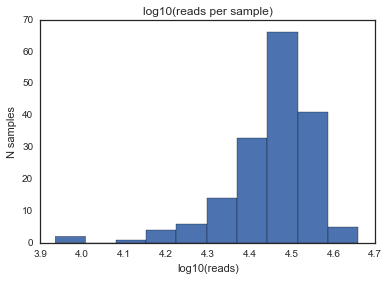

In [11]:
df.sum(axis=1).apply(np.log10).plot(kind='hist')
plt.title('log10(reads per sample)')
plt.xlabel('log10(reads)')
plt.ylabel('N samples')

In [12]:
10**4.5

31622.776601683792

Great, all samples have ~30,000 reads. 

### OTUs per sample

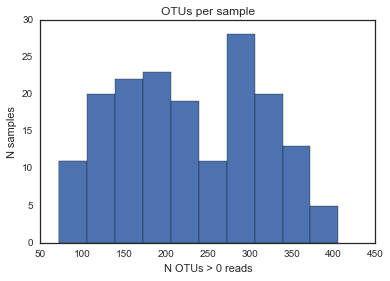

In [13]:
(df > 0).sum(axis=1).plot(kind='hist')
plt.title('OTUs per sample')
plt.xlabel('N OTUs > 0 reads')
plt.ylabel('N samples')

### OTUs per patient

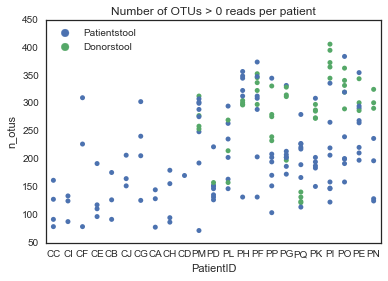

In [14]:
sns.stripplot(
    data=((df > 0)
        .sum(axis=1)
        .reset_index(name='n_otus')
        .rename(columns={'index': '#SampleID'})
        .merge(meta, right_index=True, left_on='#SampleID')
        .sort_values(by='Response')
     ),
    x='PatientID',
    y='n_otus',
    hue='Sampletype'
)
plt.legend(loc='upper left')
plt.title('Number of OTUs > 0 reads per patient')

The first few samples are controls (start with 'C'). Note that the "controls" are abx-only patients, so it makes sense that they have fewer OTUs than the patients and donors. The others look pretty normal, I guess? Usually donor stool has more OTUs than patient stool (except for PQ), and the range of number of OTUs is fine looking. 

### OTUs shared across people

In [15]:
meta.head()

Forward_read              Reverse_read         Matter  \
#SampleID                                                                      
34         34_S35_L001_R1_001.fastq  34_S35_L001_R2_001.fastq  Stool Patient   
35         35_S36_L001_R1_001.fastq  35_S36_L001_R2_001.fastq  Stool Patient   
36         36_S37_L001_R1_001.fastq  36_S37_L001_R2_001.fastq  Stool Patient   
37         37_S38_L001_R1_001.fastq  37_S38_L001_R2_001.fastq  Stool Patient   
38         38_S39_L001_R1_001.fastq  38_S39_L001_R2_001.fastq  Stool Patient   

          Identity PatientID DonorID Response    Sampletype  prepost  \
#SampleID                                                              
34         PD_S-10        PD      DB       NR  Patientstool   preABX   
35           PD_S1        PD      DB       NR  Patientstool  postABX   
36          PD_S14        PD      DB       NR  Patientstool  postFMT   
37          PD_S28        PD      DB       NR  Patientstool  postFMT   
38          PD_S42        PD      DB       NR  Patientstool  postFMT   

          Sampling_day  
#SampleID               
34                d-10  
35                  d1  
36                 d14  
37                 d28  
38                 d42

In [16]:
lst_nonzero = []
for g, subdf in meta.groupby(['PatientID', 'Sampletype']):
    # Indicated whether we're looking at donor or patient
    if g[1] == 'Patientstool':
        newid = g[0] + '_pt'
    elif g[1] == 'Donorstool':
        newid = g[0] + '_d'
    tmp = pd.DataFrame((df.loc[subdf.index] > 0).sum(), columns=['n_samples_nonzero'])
    tmp['id'] = newid
    lst_nonzero.append(tmp)

In [17]:
# This dataframe has individual people (patientID + donor/pt suffix) in rows,
# OTUs in columns, and the number of samples that OTU was nonzero in that patient
df_nonzero = pd.concat(lst_nonzero).reset_index().pivot(index='id', columns='#OTU ID', values='n_samples_nonzero')

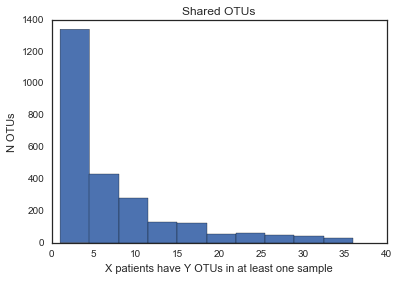

In [18]:
# Number of patients each OTU is present in
(df_nonzero > 0).sum().plot(kind='hist')
plt.title('Shared OTUs')
plt.xlabel('X patients have Y OTUs in at least one sample')
plt.ylabel('N OTUs')

In [19]:
df_nonzero.shape

(36, 2549)

In [20]:
# Number of unique people combos (well, technically I think there's fewer than this
# because a couple of the donors went with different patients. Ah, we should probably 
# re-code this at some point...)
len(meta.groupby(['PatientID', 'Sampletype']).groups.keys())

36

Okay, that looks right - most OTUs are pretty rare across people but there is a set of OTUs which are shared across all. Cool.

# Alpha diversity

In [21]:
alphadf = df.astype(int).T.apply(alph.shannon).reset_index()
alphadf.columns = ['sample_id', 'shannon']
alphadf = pd.merge(alphadf, meta, left_on='sample_id', right_index=True)
alphadf.head()

sample_id   shannon               Forward_read               Reverse_read  \
0       173  6.213258  173_S40_L001_R1_001.fastq  173_S40_L001_R2_001.fastq   
1       202  6.454356  202_S70_L001_R1_001.fastq  202_S70_L001_R2_001.fastq   
2       195  5.775235  195_S63_L001_R1_001.fastq  195_S63_L001_R2_001.fastq   
3       194  5.503455  194_S62_L001_R1_001.fastq  194_S62_L001_R2_001.fastq   
4        79  5.577162   79_S81_L001_R1_001.fastq   79_S81_L001_R2_001.fastq   

          Matter Identity PatientID DonorID Response    Sampletype  \
0     Donorstool   PM_D28        PM      DJ       NR    Donorstool   
1     Donorstool   PO_D42        PO      DL       RE    Donorstool   
2  Stool Patient   PO_S28        PO      DL       RE  Patientstool   
3  Stool Patient   PO_S14        PO      DL       RE  Patientstool   
4  Stool Patient   PG_S42        PG      DE       PR  Patientstool   

      prepost Sampling_day  
0  Donorstool          d28  
1  Donorstool          d42  
2     postFMT          d28  
3     postFMT          d14  
4     postFMT          d42

/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


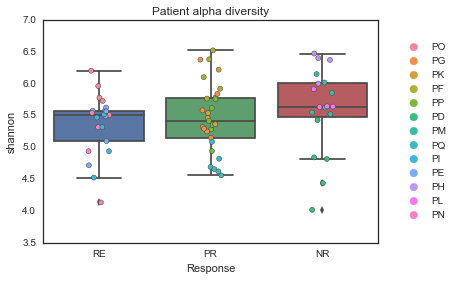

In [22]:
data = (alphadf
            .query('Sampletype == "Patientstool"')
            .query('prepost == "postFMT"')
        )
sns.boxplot(data=data, x='Response', y='shannon')
sns.stripplot(data=data, x='Response', y='shannon', 
              hue='PatientID', 
              jitter=True, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.title('Patient alpha diversity')

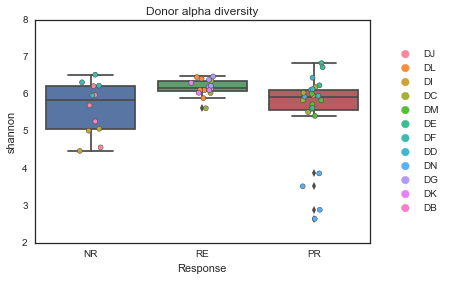

In [23]:
data = (alphadf
            .query('Sampletype == "Donorstool"')
            .query('prepost == "Donorstool"')
        )
sns.boxplot(data=data, x='Response', y='shannon')
sns.stripplot(data=data, x='Response', y='shannon', 
              hue='DonorID', 
              jitter=True, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.title('Donor alpha diversity')

Okay, that's good - we can replicate the results from the study. Interesting that there is one donor with surprisingly low alpha diversity who go partial response. (Note that for this plot and the one above, there are multiple samples per donor and patient).

## Beta diversity

Let's make a PCA plot. In the paper, they use unweighted unifrac - that requires a phylogenetic tree (which I don't want to make right now). Let's do Bray Curtis for now

In [91]:
betares = beta_diversity('braycurtis', df.astype(int).values)
betadf = betares.to_data_frame()
betadf.index = df.index
betadf.columns = df.index

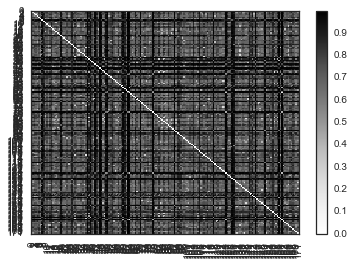

In [83]:
betares

In [65]:
# Turn to tidy format
## Oh, but actually I don't need this!! We'll keep the code here just in case...
tidybeta = betares.to_data_frame()
# beta diversity calculates distance between samples (i.e. rows)
tidybeta.columns = df.index
tidybeta.index = df.index
tidybeta.head()

sample1       173       202       195       194        79       252       137  \
sample1                                                                         
173      0.000000  0.700552  0.756613  0.739998  0.649775  0.751613  0.635388   
202      0.700552  0.000000  0.638862  0.721555  0.645501  0.815201  0.684008   
195      0.756613  0.638862  0.000000  0.448993  0.501547  0.838426  0.751389   
194      0.739998  0.721555  0.448993  0.000000  0.616768  0.748584  0.633336   
79       0.649775  0.645501  0.501547  0.616768  0.000000  0.787642  0.681083   

sample1       105       271       159    ...           39        64        97  \
sample1                                  ...                                    
173      0.990473  0.841908  0.776151    ...     0.710026  0.672144  0.709867   
202      0.969503  0.792641  0.802692    ...     0.865409  0.660922  0.732115   
195      0.871766  0.917265  0.758037    ...     0.889537  0.667601  0.767897   
194      0.959611  0.940152  0.681402    ...     0.801260  0.691920  0.765343   
79       0.961378  0.869693  0.723730    ...     0.872540  0.645136  0.731031   

sample1       142       182       157        45       245       108       187  
sample1                                                                        
173      0.597596  0.775783  0.824536  0.783647  0.619278  0.637542  0.660664  
202      0.673146  0.777217  0.870081  0.721990  0.750371  0.711582  0.478371  
195      0.738783  0.746000  0.712781  0.799450  0.668835  0.730234  0.695338  
194      0.718762  0.686135  0.704180  0.812169  0.746141  0.675458  0.740984  
79       0.678559  0.753522  0.800785  0.782828  0.623725  0.677006  0.710445  

[5 rows x 172 columns]

In [66]:
tidybeta.index.name = 'sample1'
tidybeta = (tidybeta
            .reset_index()
            .melt(id_vars='sample1', 
                  var_name='sample2', 
                  value_name='braycurtis')
            )
tidybeta.head()

sample1 sample2  braycurtis
0     173     173    0.000000
1     202     173    0.700552
2     195     173    0.756613
3     194     173    0.739998
4      79     173    0.649775

### PCoA plot

In [67]:
from sklearn.decomposition import PCA

In [92]:
ypca = PCA(random_state=12345).fit_transform(betadf.values)
ypca

array([[-9.39618239e-01, -5.09136064e-01, -1.46701354e-01, ...,
         5.07168649e-03, -5.51018759e-04,  4.54397413e-16],
       [-6.56169799e-01, -7.06429619e-01, -1.88099818e-01, ...,
        -2.62047485e-03,  1.50340783e-03,  4.54397413e-16],
       [-3.34961169e-01, -3.63570341e-01,  2.24250244e-01, ...,
        -8.46129382e-04, -1.78609076e-03,  4.54397413e-16],
       ...,
       [-3.19614806e-01, -4.38671325e-01,  8.74153910e-02, ...,
        -9.32836201e-03, -1.96072836e-03,  4.54397413e-16],
       [-1.37742781e+00,  8.79915153e-01, -2.34244632e-01, ...,
        -1.92873969e-03,  3.24921985e-03,  4.54397413e-16],
       [-7.01517685e-01, -6.58674401e-01, -5.88616538e-01, ...,
        -9.83735258e-04,  3.44557753e-03,  4.54397413e-16]])

In [93]:
def make_toplot(ypca, samples, meta):
    """
    Make a dataframe with PC columns from ypca (numpy array).
    Merge meta (dataframe) on 'sample_id' with the samples in samples (list)
    """

    dfpca = pd.DataFrame(data=ypca, 
                         index=samples, 
                         columns=['PC' + str(i) for i in range(1, ypca.shape[1]+1)])
    
    dfpca = pd.merge(dfpca, meta, left_index=True, right_index=True, how='left')

    return dfpca

In [94]:
dfpca = make_toplot(ypca, df.index.tolist(), meta)

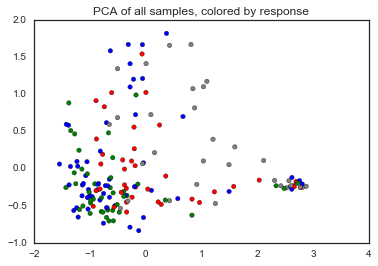

In [110]:
cdict = {'NR': 'red', 'RE': 'green', 'PR': 'blue', 'Control': 'gray'}
plt.scatter(dfpca['PC1'], dfpca['PC2'], c=[cdict[i] for i in meta.loc[df.index, 'Response']])
plt.title('PCA of all samples, colored by response')

Pretty unclear (also lol looks like literally every PCA plot I've made in my PhD gahhh).

Let's look only at the RE/NR samples (like they did in the paper)

In [111]:
keep_responses = ['RE', 'NR']
samples = meta.query('Response == @keep_responses').index.tolist()
pca_nrne = PCA(random_state=12345).fit_transform(betadf.loc[samples, samples])
dfpca_nrne = make_toplot(pca_nrne, samples, meta)

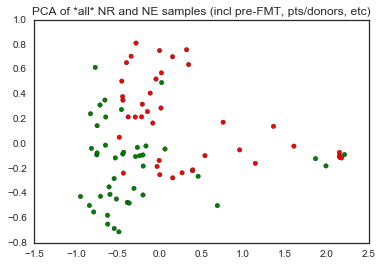

In [112]:
plt.scatter(dfpca_nrne['PC1'], dfpca_nrne['PC2'], 
            c=[cdict[i] for i in meta.loc[samples, 'Response']])
plt.title('PCA of *all* NR and NE samples (incl pre-FMT, pts/donors, etc)')

Hm, interesting. In the paper they only plotted the donor stool for this plot. Here I'm including both donor and patient stools. Already you see the separation between remission and no response (green and red) - plus a clump of samples over at ~(2, 0). Wonder who these are...

In [113]:
showcols = ['PC1', 'PC2', 'PC3', 'Identity', 'PatientID', 'DonorID', 'Response', 'Sampletype', 'prepost', 'Sampling_day']
dfpca_nrne.query('PC1 > 2.0').query('(PC2 < 0.0) & (PC1 > -0.2)')[showcols]

PC1       PC2       PC3 Identity PatientID DonorID Response  \
35   2.152280 -0.110878 -0.113133    PD_S1        PD      DB       NR   
91   2.149019 -0.098498 -0.168503    PH_S1        PH      DF       NR   
152  2.173413 -0.115668 -0.101424    PL_S1        PL      DI       NR   
164  2.148549 -0.071440 -0.152952    PM_S1        PM      DJ       NR   
180  2.209538 -0.088575 -0.167002    PN_S1        PN      DK       RE   

       Sampletype  prepost Sampling_day  
35   Patientstool  postABX           d1  
91   Patientstool  postABX           d1  
152  Patientstool  postABX           d1  
164  Patientstool  postABX           d1  
180  Patientstool  postABX           d1

Okay, so it's just 5 samples (good), and all of them are on day 1 post abx. Interesting! And also comforting - I'm guessing these are low diversity samples or something else weird is going on. Let's check the diversity

In [114]:
clumped_samples = dfpca_nrne.query('PC1 > 2.0').query('(PC2 < 0.0) & (PC1 > -0.2)').index.tolist()
alphadf.query('sample_id == @clumped_samples')

sample_id   shannon               Forward_read               Reverse_read  \
49        164  2.556996  164_S31_L001_R1_001.fastq  164_S31_L001_R2_001.fastq   
92        180  2.208913  180_S47_L001_R1_001.fastq  180_S47_L001_R2_001.fastq   
117       152  3.443730  152_S18_L001_R1_001.fastq  152_S18_L001_R2_001.fastq   
125        91  3.588229   91_S93_L001_R1_001.fastq   91_S93_L001_R2_001.fastq   
144        35  3.710857   35_S36_L001_R1_001.fastq   35_S36_L001_R2_001.fastq   

            Matter Identity PatientID DonorID Response    Sampletype  prepost  \
49   Stool Patient    PM_S1        PM      DJ       NR  Patientstool  postABX   
92   Stool Patient    PN_S1        PN      DK       RE  Patientstool  postABX   
117  Stool Patient    PL_S1        PL      DI       NR  Patientstool  postABX   
125  Stool Patient    PH_S1        PH      DF       NR  Patientstool  postABX   
144  Stool Patient    PD_S1        PD      DB       NR  Patientstool  postABX   

    Sampling_day  
49            d1  
92            d1  
117           d1  
125           d1  
144           d1

Sure enough, these are very low alpha diversity. (Note: I didn't plot these in the alpha diversity boxplot because they're not post-FMT).

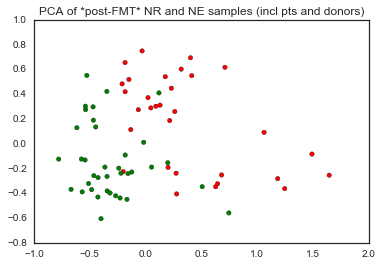

In [116]:
keep_responses = ['RE', 'NR']
keep_prepost = ['postFMT', 'Donorstool']
samples = meta.query('Response == @keep_responses').query('prepost == @keep_prepost').index.tolist()
pca_postfmt = PCA(random_state=12345).fit_transform(betadf.loc[samples, samples])
dfpca_postfmt = make_toplot(pca_postfmt, samples, meta)


plt.scatter(dfpca_postfmt['PC1'], dfpca_postfmt['PC2'], 
            c=[cdict[i] for i in meta.loc[samples, 'Response']])
plt.title('PCA of *post-FMT* NR and NE samples (incl pts and donors)')

I don't think I need to keep going down this rabbit hole - looks like their results do recapitulate here. Onwards with my analyses!